# **Data Cleaning**

## Objectives
---

* Evaluate missing data
* Create data cleaning pipline and ready the data to output to model

## Steps
---

* Create data imputer pipilines

## Change working directory
---

First we set the working directory for the notebook.

In [1]:
import os
current_dir = os.getcwd()
current_dir
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(current_dir)

/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor


## Load Data
---

Load the data in from the outputs section of the last notebook.

In [2]:
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/house_prices.csv")
df_inherited = pd.read_csv("outputs/datasets/collection/inherited_houses.csv")
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,4,6,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,7,5,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,4,6,920,NaN,2001,2002,223500


## Data Exploration
---

We can use a library called pandas-profiling to explore the dataset with a GUI that will give us insights into the characteristics of each feature and the relationships they share with each other.

In [3]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

/var/folders/ph/7d3cvxsn1q3c_q7whlj76_lh0000gn/T/ipykernel_38138/962869596.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Correlation and PPS Analysis

We can use a custom function taken from the codeinstitute modules to display heatmaps for pearson and spearman correlation analyses as well as a heatmap for the Power Predictive Score for the variables.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


We run the function on the dataset.

In [5]:
%matplotlib inline
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/var/folders/ph/7d3cvxsn1q3c_q7whlj76_lh0000gn/T/ipykernel_38138/1953412673.py:36: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr_spearman = df.corr(method="spearman")
/var/folders/ph/7d3cvxsn1q3c_q7whlj76_lh0000gn/T/ipykernel_38138/1953412673.py:37: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr_pearson = df.corr(method="pearson")
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/Users/matthewmurnaghan/Data-Science-Pro

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



/var/folders/ph/7d3cvxsn1q3c_q7whlj76_lh0000gn/T/ipykernel_38138/1953412673.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df, dtype=np.bool)


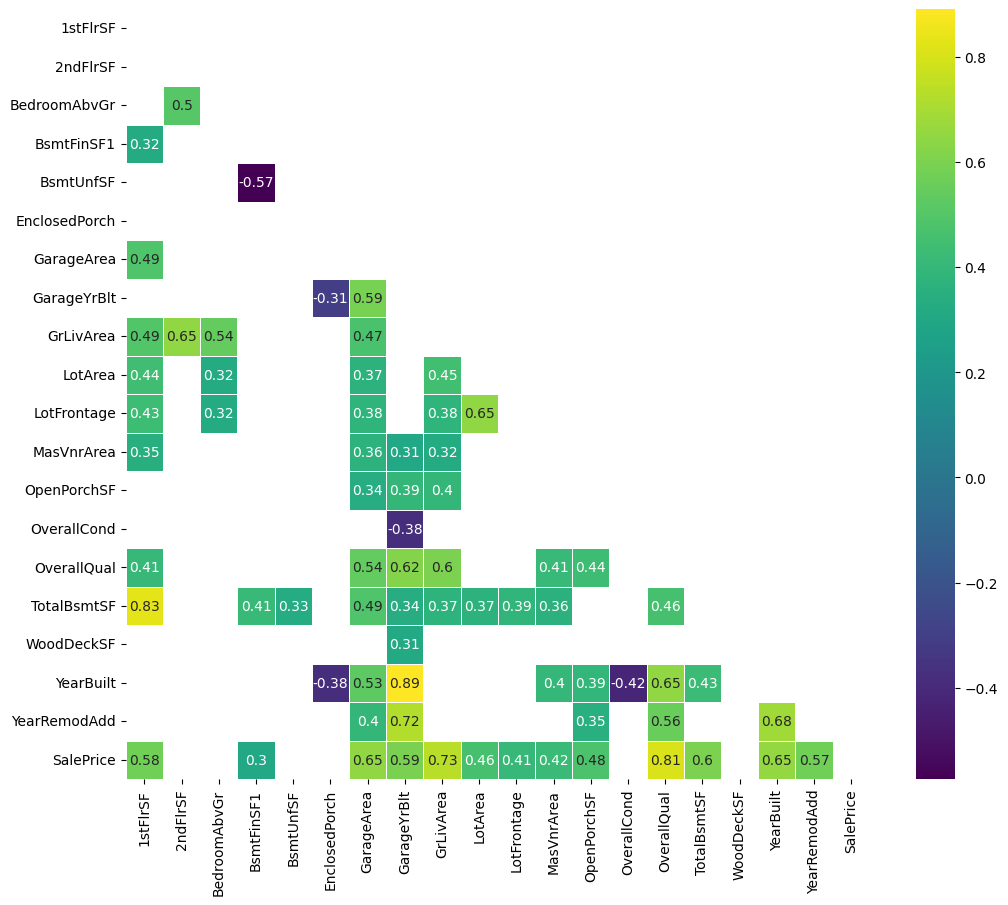



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



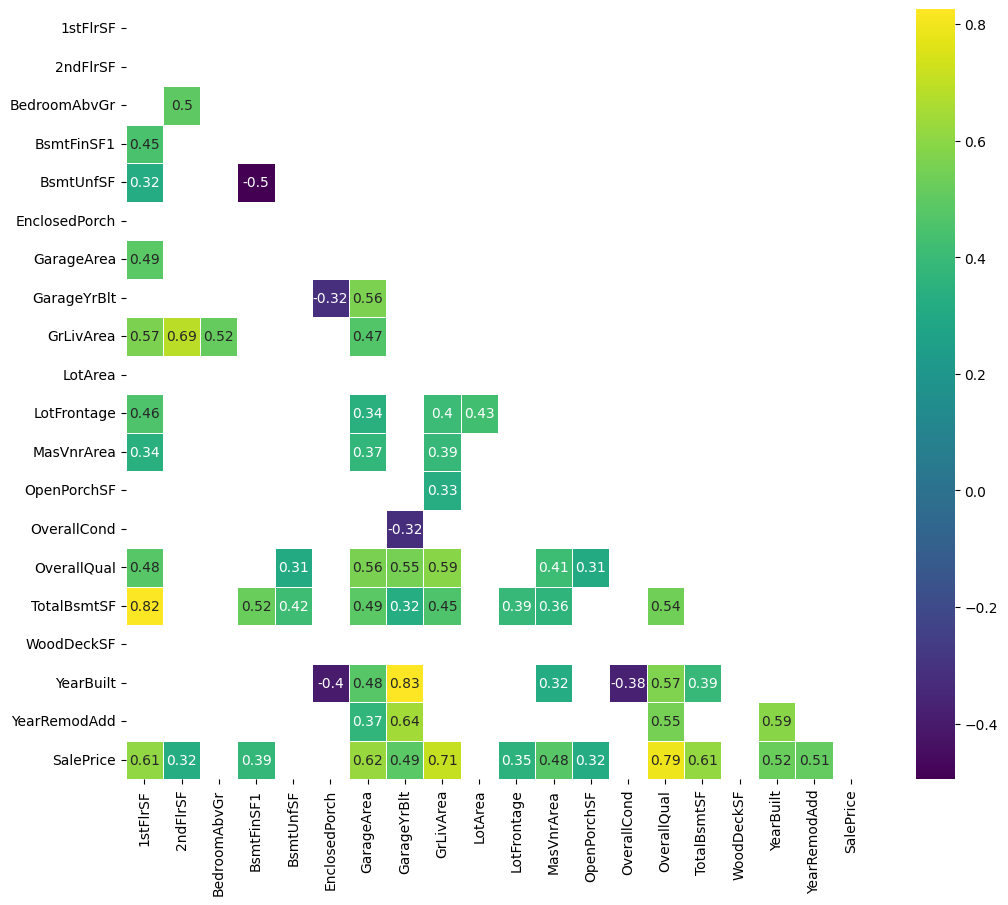



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



/var/folders/ph/7d3cvxsn1q3c_q7whlj76_lh0000gn/T/ipykernel_38138/1953412673.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df, dtype=np.bool)


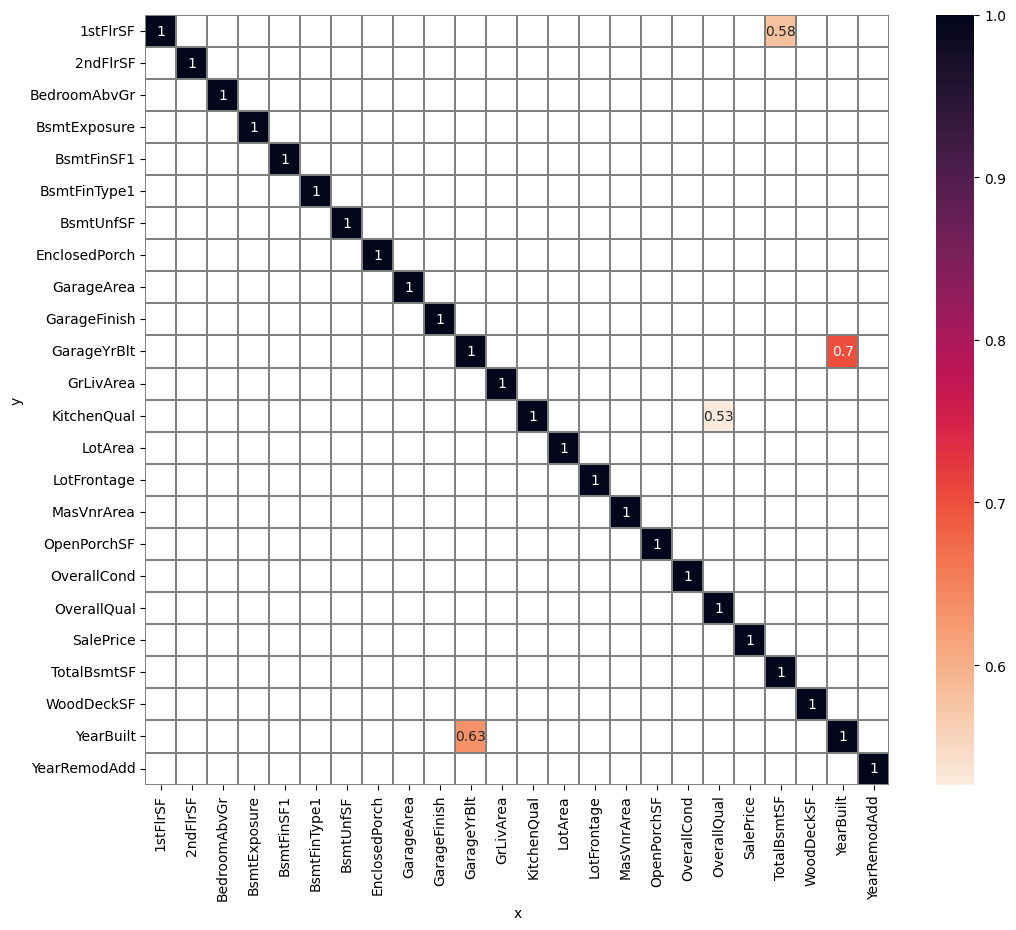

In [6]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.3, PPS_Threshold =0.5,
                  figsize=(12*1,10*1), font_annot=10)

These charts give us an understanding of the correlative relationships between the different variables contained within the dataset. It can help to refer to these charts when making decisions about how to handle any missing data contained within the datasets.

## Train and Test
---

We need to split the data into train and test sets.

In [7]:
from sklearn.model_selection import train_test_split
train_set, test_set, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"train_set shape: {train_set.shape} \ntest_set shape: {test_set.shape}")

train_set shape: (1168, 24) 
test_set shape: (292, 24)


## Assessing Missing Data Levels

This is a custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type. It is taken from the codeinstute modules for datacleaning.

In [8]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data


This function allows us to evaluate the effect that the datacleaning has had on the dataset visually. It is also taken from the codeinstitute modules on datacleaning.

In [9]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate the plot number
  
  # Distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over the variables, 
    # first on variables that you applied to the method
    # if the variable is numerical plot a histogram, if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

We need to evaluate the missing data levels on the train set.

In [10]:
df_missing = EvaluateMissingData(train_set)
print(f"* There are {df_missing.shape[0]} variables with missing data \n")
df_missing

* There are 9 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1056,90.41,float64
WoodDeckSF,1034,88.53,float64
LotFrontage,212,18.15,float64
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
MasVnrArea,6,0.51,float64


* We can see that there are two variables with approximately 90% of their data missing, EnclosedPorch and WoodDeckSF.
* There are 7 other features that contain smaller ammounts of missing data.
* These features would be suitable candidates for feature engineering and imputation.

## High percentage of missing data
---

There are two variables with a high percentag of missing data:
* EnclosedPorch
* WoodDeckSF

### EnclosedPorch
* This Variable is missing 90.41% of its data.
* Considering that large ammount of data that is missing, this variable is a good candidate to drop from the dataset as it will add little value to calculating the SalePrice.
* The PPS heatmap shows that this variable has no preictive power, re-enforcing the decision to drop it from the dataset.

### WoodDeckSF
* This Variable is missing 88.53% of its data.
* Considering that large ammount of data that is missing, this variable is a good candidate to drop from the dataset as it will add little value to calculating the SalePrice.
* The PPS heatmap shows that this variable has no preictive power, re-enforcing the decision to drop it from the dataset.

## Medium/Low percentage of missing data
---

There are seven remaining variables to be reviewed that are good candidates for data cleaning.
* LotFrontage
* GarageFinish
* BsmtFinType1
* BedroomAbvGr
* 2ndFlrSF
* GarageYrBlt
* MasVnrArea

### Data Analysis

* Analysing the remainig variables, we can see that they are split into distinct groups:
    * Discrete
    * Continuous



### Discrete Data

The variables that are missing data that are also discretised are:
* GarageFinish
* BsmtFinType1
* BedroomAbvGr
* GarageYrBlt

Please note that GarageFinish and BsmtFinType1 are both categorical variables, but are discrete none the less.

As these variables have small ammounts of missing data, between 0.5% and 11%, we can use modal imputation to replace the missing data with the most commonly observed datapoints in each variable observation.

This should retain most of the information contained within each variable without altering them too much.

### Continuous data

The variables that are missing data that are not discretised are:
* MasVnrArea
* 2ndFlrSF
* LotFrontage

Based on this information and information gathered from the pandas report, we can conclude that:
* The datapoints for the above variables are all numerical.
* Each datapoint has a kurtotis level that is greater than |0.5|, therefore they are not normally distributed.
* We can use median imputation to insert the median value where data is missing, as the median is less affected by outliers.

## Data Cleaning Pipeline
---

We can now create our data cleaning pipeline, using the median, frequent-categorical and Drop imputation methods from the feature engine lirbary.
1. We create a section of the pipeline to drop EnclosedPorch and WoodDeckSF from the train set called 'DropFeat'.
2. 
2. We create a section of the pipeline to replace the discretised data with modal values called 

We need to cast the encoded data in the dataset as type object, as we have already completed the data encoding in the first data collection notebook.

In [11]:
categorical_variables = ['GarageFinish', 'BsmtFinType1', 'GarageYrBlt', 'KitchenQual', 'OverallQual', 'OverallCond']

train_set[categorical_variables] = train_set[categorical_variables].astype('category')
test_set[categorical_variables] = test_set[categorical_variables].astype('category')
df[categorical_variables] = df[categorical_variables].astype('category')
df_inherited[categorical_variables] = df_inherited[categorical_variables].astype('category')


In [12]:
train_set.info()
train_set.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 618 to 684
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   1stFlrSF       1168 non-null   int64   
 1   2ndFlrSF       1108 non-null   float64 
 2   BedroomAbvGr   1088 non-null   float64 
 3   BsmtExposure   1168 non-null   object  
 4   BsmtFinSF1     1168 non-null   int64   
 5   BsmtFinType1   1079 non-null   category
 6   BsmtUnfSF      1168 non-null   int64   
 7   EnclosedPorch  112 non-null    float64 
 8   GarageArea     1168 non-null   int64   
 9   GarageFinish   1037 non-null   category
 10  GarageYrBlt    1110 non-null   category
 11  GrLivArea      1168 non-null   int64   
 12  KitchenQual    1168 non-null   category
 13  LotArea        1168 non-null   int64   
 14  LotFrontage    956 non-null    float64 
 15  MasVnrArea     1162 non-null   float64 
 16  OpenPorchSF    1168 non-null   int64   
 17  OverallCond    1168 non-null   c

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
763,1268,1097.0,NaN,Mn,1163,GLQ,89,NaN,856,NaN,...,82.0,673.0,128,4,7,1252,NaN,1999,1999,337000
835,1067,0.0,2.0,No,442,BLQ,625,NaN,436,Unf,...,60.0,0.0,0,6,3,1067,NaN,1950,1995,128000
1216,1318,584.0,4.0,None,0,None,0,NaN,539,Unf,...,68.0,0.0,0,4,5,0,NaN,1978,1978,112000
559,1557,0.0,2.0,Gd,0,Unf,1374,NaN,420,Fin,...,NaN,18.0,20,4,6,1374,NaN,2003,2004,234000
684,1195,644.0,4.0,No,0,Unf,1195,NaN,486,Fin,...,58.0,30.0,81,4,6,1195,NaN,1998,1998,221000


In [13]:
from feature_engine.encoding import OrdinalEncoder
categorical_variables = ['GarageFinish', 'BsmtFinType1', 'GarageYrBlt', 'KitchenQual',]
# train_set[categorical_variables] = train_set[categorical_variables].astype('category')
# test_set[categorical_variables] = test_set[categorical_variables].astype('category')

In [14]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 618 to 684
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   1stFlrSF       1168 non-null   int64   
 1   2ndFlrSF       1108 non-null   float64 
 2   BedroomAbvGr   1088 non-null   float64 
 3   BsmtExposure   1168 non-null   object  
 4   BsmtFinSF1     1168 non-null   int64   
 5   BsmtFinType1   1079 non-null   category
 6   BsmtUnfSF      1168 non-null   int64   
 7   EnclosedPorch  112 non-null    float64 
 8   GarageArea     1168 non-null   int64   
 9   GarageFinish   1037 non-null   category
 10  GarageYrBlt    1110 non-null   category
 11  GrLivArea      1168 non-null   int64   
 12  KitchenQual    1168 non-null   category
 13  LotArea        1168 non-null   int64   
 14  LotFrontage    956 non-null    float64 
 15  MasVnrArea     1162 non-null   float64 
 16  OpenPorchSF    1168 non-null   int64   
 17  OverallCond    1168 non-null   c

Now we can create the pipeline for data cleaning.

In [15]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures
from feature_engine.imputation import MeanMedianImputer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.imputation import CategoricalImputer

categorical_variables = ['GarageFinish', 'BsmtFinType1', 'GarageYrBlt', 'KitchenQual',]
numerical_variables = ['MasVnrArea', '2ndFlrSF', 'LotFrontage', 'BedroomAbvGr']

data_cleaning_pipeline = Pipeline([
      ('DropFeat', DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF']) ),
      ('MeanMedianImputer', MeanMedianImputer(imputation_method='median', variables=numerical_variables)),
      ('CategoricalImputer', CategoricalImputer(imputation_method='frequent',variables=categorical_variables)),
])

data_cleaning_pipeline

Pipeline(steps=[('DropFeat',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['MasVnrArea', '2ndFlrSF',
                                              'LotFrontage', 'BedroomAbvGr'])),
                ('CategoricalImputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['GarageFinish', 'BsmtFinType1',
                                               'GarageYrBlt',
                                               'KitchenQual']))])

### Fit The Pipeline

Now we fit_transform the train set to the data cleaning pipeline to get the output dataframe, with no missing data. We can save a copy of the original train set to compare the size before and after the pipeline has been fit.

In [16]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 618 to 684
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   1stFlrSF       1168 non-null   int64   
 1   2ndFlrSF       1108 non-null   float64 
 2   BedroomAbvGr   1088 non-null   float64 
 3   BsmtExposure   1168 non-null   object  
 4   BsmtFinSF1     1168 non-null   int64   
 5   BsmtFinType1   1079 non-null   category
 6   BsmtUnfSF      1168 non-null   int64   
 7   EnclosedPorch  112 non-null    float64 
 8   GarageArea     1168 non-null   int64   
 9   GarageFinish   1037 non-null   category
 10  GarageYrBlt    1110 non-null   category
 11  GrLivArea      1168 non-null   int64   
 12  KitchenQual    1168 non-null   category
 13  LotArea        1168 non-null   int64   
 14  LotFrontage    956 non-null    float64 
 15  MasVnrArea     1162 non-null   float64 
 16  OpenPorchSF    1168 non-null   int64   
 17  OverallCond    1168 non-null   c

In [17]:
train_set_original = train_set.copy()
train_set = data_cleaning_pipeline.fit_transform(train_set)

We check the resulting dataframe for null values.

In [18]:
train_set.isnull().sum()

1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
LotFrontage     0
MasVnrArea      0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
SalePrice       0
dtype: int64

We can check to confirm that the train set is the same shape and size as it was before we fit the data cleaning pipeline. This shows us that the no datapoints were lost, and that we have merely imputed the missing data with the methods specified in the pipeline.

In [19]:
print(train_set.shape)
print(train_set_original.shape)

(1168, 22)
(1168, 24)


We can see that the original train set and the new train set have the same number of rows, but with two less columns as we have dropped the EnclosedPorch column and the WoodDeckSF column due to the large amounts of missing data.

We now have a cleaned train set that is ready for feature engineering. We now apply the same to the test set.

In [20]:
test_set = data_cleaning_pipeline.fit_transform(test_set)

We check for null values:

In [21]:
test_set.isnull().sum()

1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
LotFrontage     0
MasVnrArea      0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
SalePrice       0
dtype: int64

In [22]:
df_cleaned = data_cleaning_pipeline.fit_transform(df)

### Compare Dataframes before and after cleaning

We can check to see what effect the cleaning has had on the data distribution.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['MasVnrArea', '2ndFlrSF', 'LotFrontage', 'GarageFinish', 'BsmtFinType1', 'BedroomAbvGr', 'GarageYrBlt'] 




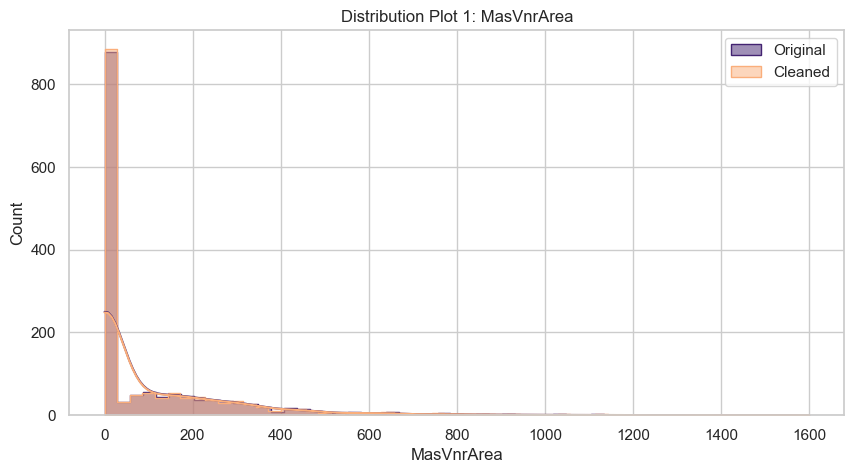

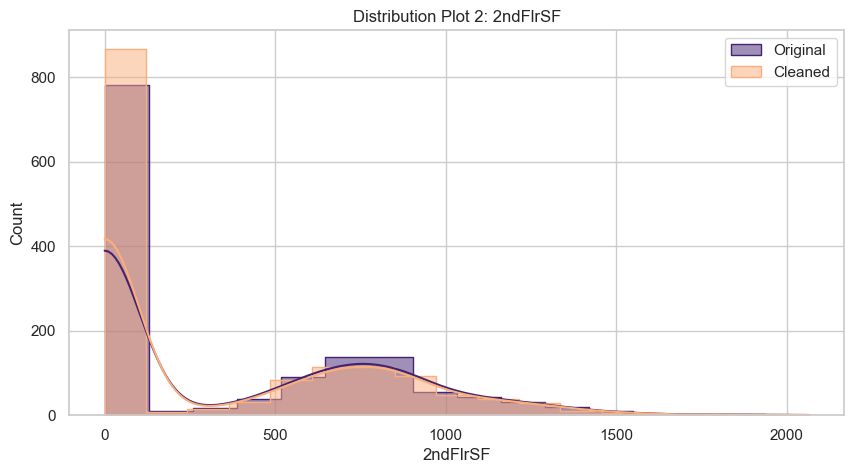

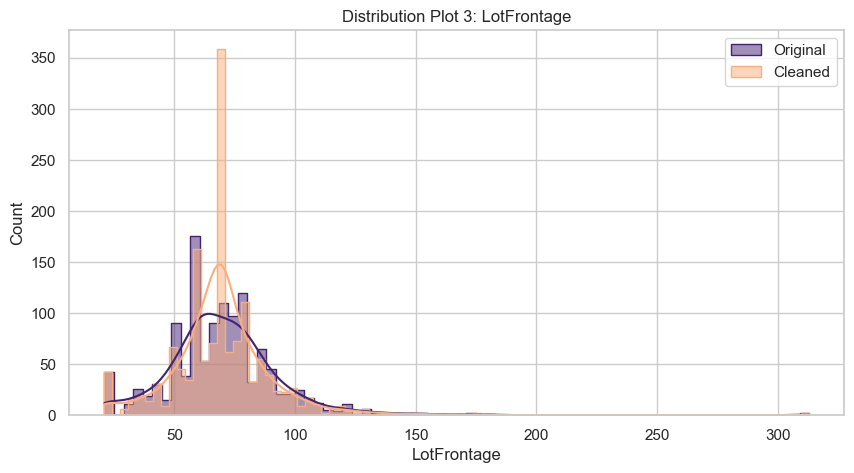

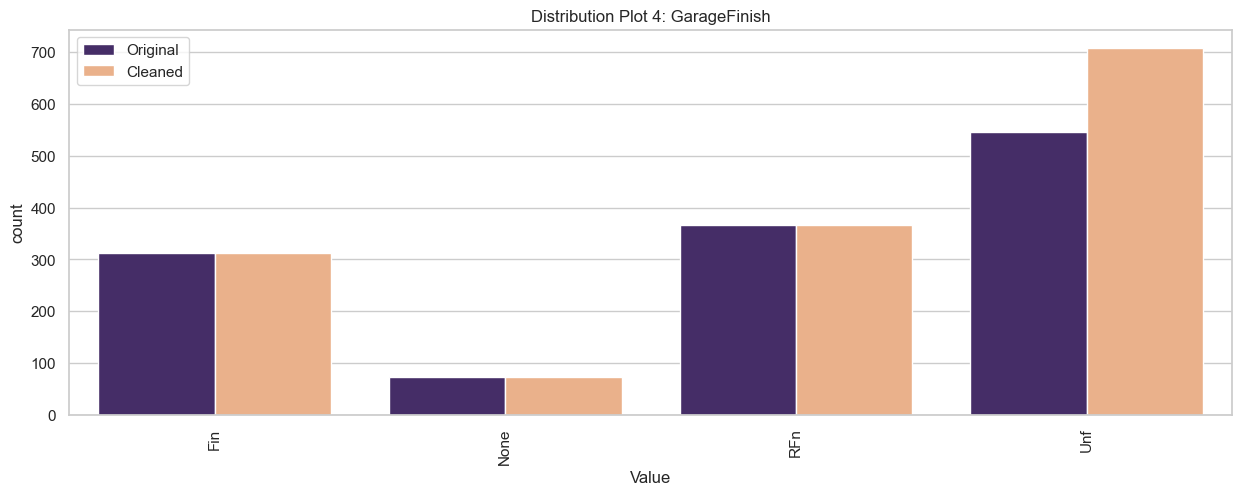

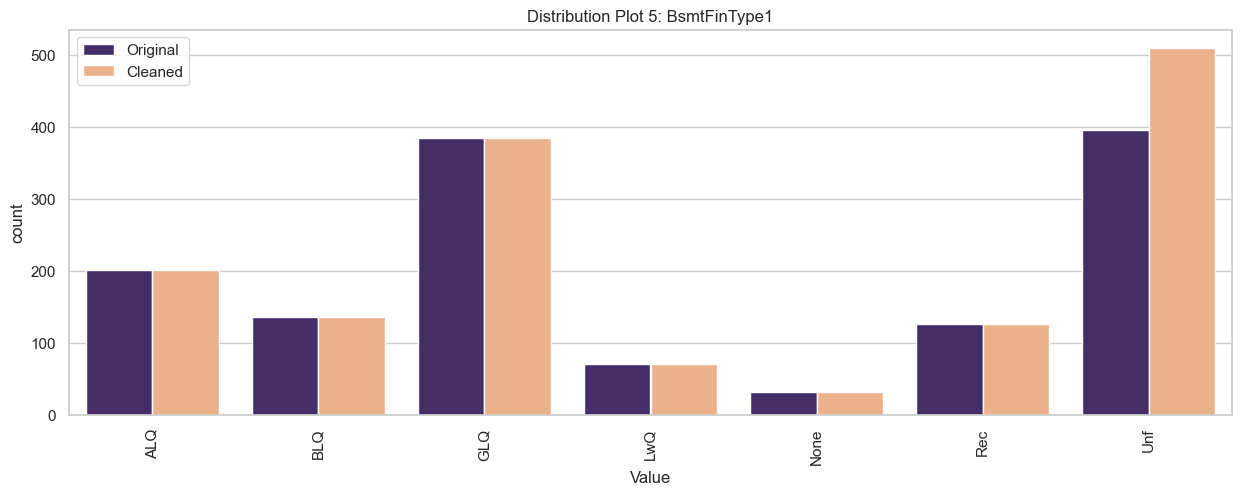

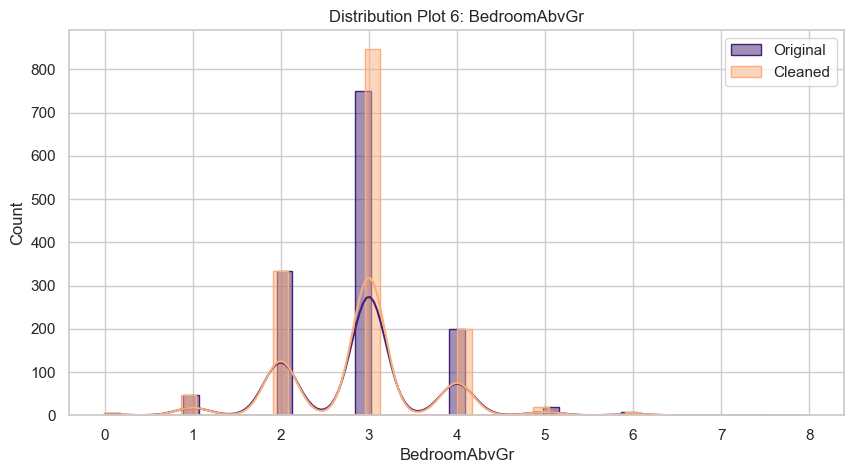

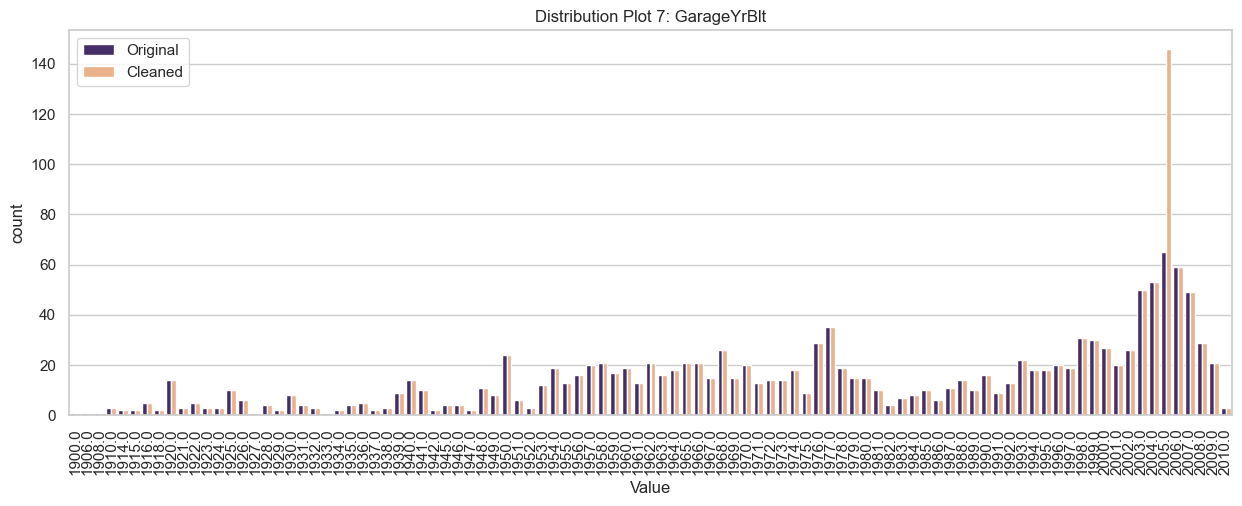

In [23]:
DataCleaningEffect(df_original=df,
                   df_cleaned=df_cleaned,
                   variables_applied_with_method=['MasVnrArea', '2ndFlrSF', 'LotFrontage', 'GarageFinish', 'BsmtFinType1', 'BedroomAbvGr', 'GarageYrBlt'])

## Convert float to int
---

We need to convert the floating point values in the dataset to integer values as none of the values included have an values after the decimal point.

In [24]:
for col in train_set.select_dtypes('float').columns:
    train_set[col] = train_set[col].astype('int64')

for col in test_set.select_dtypes('float').columns:
    test_set[col] = test_set[col].astype('int64')

In [25]:
train_set.dtypes

1stFlrSF           int64
2ndFlrSF           int64
BedroomAbvGr       int64
BsmtExposure      object
BsmtFinSF1         int64
BsmtFinType1    category
BsmtUnfSF          int64
GarageArea         int64
GarageFinish    category
GarageYrBlt     category
GrLivArea          int64
KitchenQual     category
LotArea            int64
LotFrontage        int64
MasVnrArea         int64
OpenPorchSF        int64
OverallCond     category
OverallQual     category
TotalBsmtSF        int64
YearBuilt          int64
YearRemodAdd       int64
SalePrice          int64
dtype: object

## Save Output Data
--- 

Now that the data has been cleaned and there are no missing values, we can save it to our outputs folder.

We first create the 'outputs/datasets/cleaned' folder:

In [26]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/collection folder
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/datasets/cleaned'


Try to create folder for pipelines in outputs.

In [27]:
import os
try:
    os.makedirs(name='outputs/pipelines') # create outputs/datasets/collection folder
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/pipelines'


Save datacleaning pipeline to outputs.

In [28]:
import joblib
joblib.dump(value=data_cleaning_pipeline ,filename=f"outputs/pipelines/data_cleaning_pipeline.pkl")

['outputs/pipelines/data_cleaning_pipeline.pkl']

Next we save each of the cleaned dataframes as csv files.

In [29]:
train_set.to_csv("outputs/datasets/cleaned/train_set.csv", index=False)
test_set.to_csv("outputs/datasets/cleaned/test_set.csv", index=False)
df_cleaned.to_csv("outputs/datasets/cleaned/clean_house_price_records.csv", index=False)
df_inherited.to_csv("outputs/datasets/cleaned/inherited_house_price_records.csv", index=False)


## Conclusion
---

* So far we have loaded the data from the online dataset and constructed a pipeline for cleaning the data.
* We dropped two columns from the dataset as they had approximately 90% missing data.
* We used imputation methods from feature engine to replace the missing data in 7 other variables.

## Next Step

Next we can move onto feature engineering in the next notebook.